# Introduction

- Provide a project overview and a clear problem description, including a history of how the problem came about and why the problem is important/interesting.
- Describe how you acquired the data and provide a concise summary of any cleaning steps taken (i.e., summarize how you cleaned the data in the  pre-processing notebook).
- Give an outline of the rest of the report and list any key assumptions made to simplify problems.
- Briefly summarize your overall approach.

The Design Innovation Lab has a series of 3D printers utilized by everyone from InterEGR 170 to PhD researchers. Over the years, the space has accumulated many different printers aligned with different use cases. As well, staff must maintain and help users print on these printers. This brings about two questions: (1) what are the use cases and segments of customers that use the printers, and (2) when do they need help from staff. This question can help the space effectively identify new printers to purchase, as well as when to staff more or less employees. 

We acquired the data directly as Marley is an employee of the Design Innovation Lab. As for data cleaning we dropped rows with null values as it would be hard to work with rows that have null values. We also dropped a duplicate column that was named ‘Print ID’ as it would skew our data analysis. We also dropped many rows that weren’t necessary to what we were trying to find. Things such as if they needed help from staff, if they had subitems, what their job status is, tracking of the print process, the materials people requested, links and IP addresses, status of the printers, if they are doing it for a course/org, instructions, material items, agreements and understanding, if any archive data was needed, print counts, payment information, username, and additional cost.

Our first goal is to split the customer base into four sections that use the 3D printers in different ways. The four sections will be basic undergrad, advanced undergrad, grad, and faculty. Two of these sections are already done for us within the data we have; however, splitting the undergrads into basic and advanced will require us to do clustering. Once we have these sections, we can analyze them and determine specific trends within them.


We also want to figure out when people come in and do their prints. To do this, we are going to split the date into both a day of the week and time of the day. This information will be used to determine how much staffing in the design lab will be required at certain times.

Unfortunately, this data is not comprehensive and we will have to make some assumptions in continuing with this report. The first assumption we are making is that all Faculty/Staff are from the university. Occasionally, external groups will use the printers and get labeled as such. The second assumption is that our data thoroughly represents week-to-week trends. Since our data is only from this semester, we are only able to find week-to-week trends rather than trends by the semester.

# Descriptive Analysis

In [1]:
#Import Statements
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

- Load the (cleaned) dataset into a Pandas DataFrame. 
- Use at least one method (e.g., Pivot Tables, PCA, Clustering) to provide a descriptive analysis of the data. 
- Include at least one chart to enhance your analysis. 
- Describe any insight you gained from your analysis. Are there any surprises?
- Use Markdown cells to provide written analysis where appropriate. 

### Time of Printer Demand Pivot Tables

In [2]:
# Load fresh dataset
df = pd.read_csv('cleaned_dataset.csv')

# Turn Creation Log into datetime and take required infromation from it
df['Creation Log'] = pd.to_datetime(df['Creation Log'])
df['Weekday'] = df['Creation Log'].dt.day_name()

# Get information on the time of day
df['Time'] = df['Creation Log'].dt.time
df['Hour'] = df['Creation Log'].dt.hour

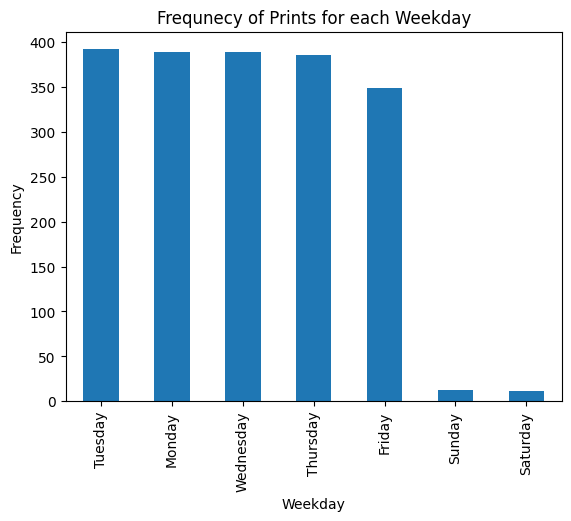

In [3]:
# Check what days people are getting 3D prints
ax = df['Weekday'].value_counts().plot.bar(ylabel='Frequency', title='Frequnecy of Prints for each Weekday')

Most of the weekdays are fairly similar on the amount of people who come in. However Friday has a solid drop which is most\
likely due to students not doing prints and enjoying their weekend. Saturday and Sunday also have some prints, but these\
are all from Staff since the lab itself is not open on the weekends. These were very interesting to see, as we didn't\
expect the weekdays to be as similar as they were 

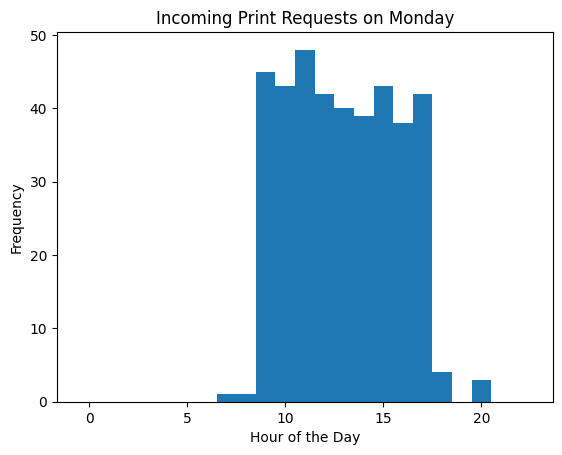

In [4]:
# Check the times people are coming in based on the weekday
hour_bins = [ x-0.5 for x in range(0, 24) ]
ax = df[ df['Weekday'] == 'Monday' ].Hour.plot.hist(bins=hour_bins, xlabel='Hour of the Day', title='Incoming Print Requests on Monday')

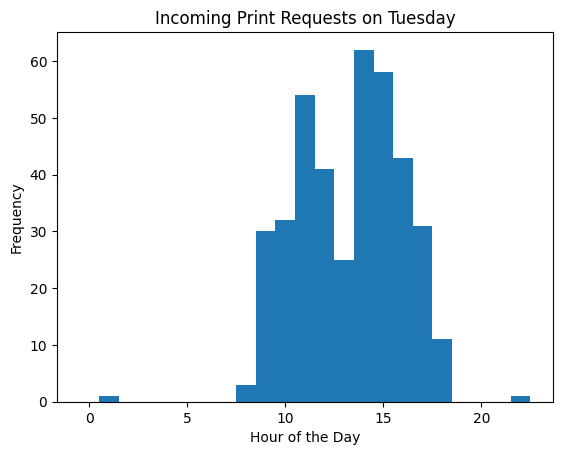

In [5]:
ax = df[ df['Weekday'] == 'Tuesday' ].Hour.plot.hist(bins=hour_bins, xlabel='Hour of the Day', title='Incoming Print Requests on Tuesday')

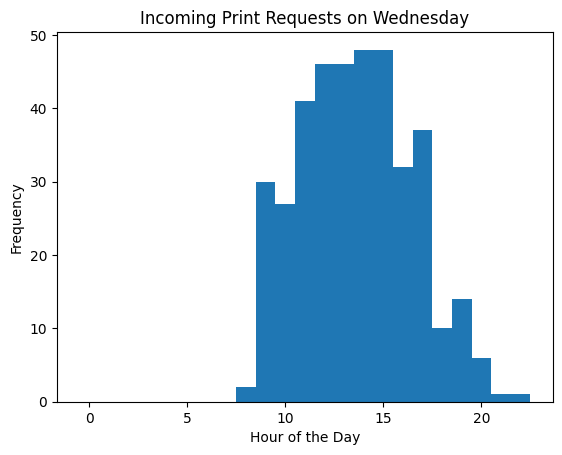

In [6]:
ax = df[ df['Weekday'] == 'Wednesday' ].Hour.plot.hist(bins=hour_bins, xlabel='Hour of the Day', title='Incoming Print Requests on Wednesday')

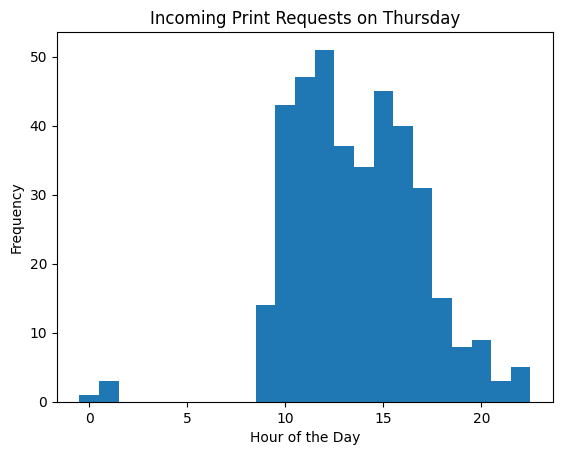

In [7]:
ax = df[ df['Weekday'] == 'Thursday' ].Hour.plot.hist(bins=hour_bins, xlabel='Hour of the Day', title='Incoming Print Requests on Thursday')

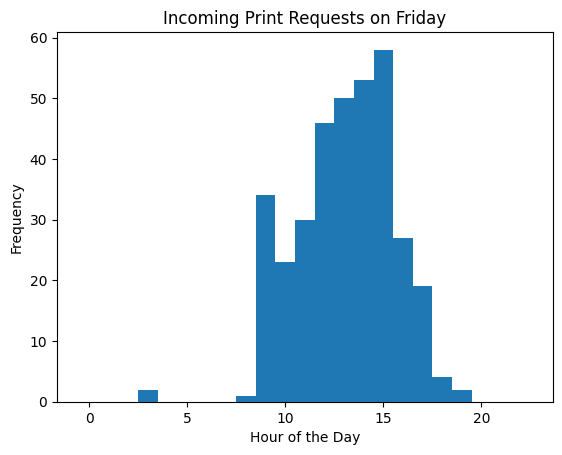

In [8]:
ex = df[ df['Weekday'] == 'Friday'].Hour.plot.hist(bins=hour_bins, xlabel='Hour of the Day', title='Incoming Print Requests on Friday')

Each weekday exhibits very different trends:
- Monday is a pretty consistent day with relatively similar frequencies on all hours having its peek at noon
- Tuesday and Thursday have a more bimodal histogram with late morning and mid afternoon rushes
- Wednesday has a small early morning rush with a main peak in the early afternoon and being more slow otherwise
- Friday has a similar structure to Wednesday, but is more lopsided in shape slowly increasing during its early afternoon until falling almost no one wants to come in later in the day

It is very cool to see how the different days differ and how each one tells a different story. Monday is a more proactive day as it's the first day of the week so time of day doesn't matter as much. The difference between Tuesdays and Thursdays and the others are most likley due to how classes are set up differently on those days. Friday having far less prints with it being the day before the weekend.

### PCA

In [9]:
df = pd.read_csv('cleaned_dataset.csv')
categorical_cols = ['User Type', 'Material 1', 'Material 2', 'Select Printer', 'Printer Requested', 'Printed On','Material_Category1', 'Sliced by']

# Convert categorical variables to numerical using Label Encoding
label_encoders = {}
value_mappings = {}

for col in categorical_cols:
    # Create a label encoder for each categorical column
    label_encoders[col] = LabelEncoder()
    
    # Fill missing values with 'missing' before encoding
    df[col] = df[col].fillna('missing')
    
    # Fit and transform the column
    df[col] = label_encoders[col].fit_transform(df[col])
    
    # Store the mapping between original values and encoded values
    value_mappings[col] = dict(zip(label_encoders[col].classes_, 
                                 label_encoders[col].transform(label_encoders[col].classes_)))

# Display the mappings for each categorical column
for col, mapping in value_mappings.items():
    print(f"\nMapping for {col}:")
    for original, encoded in mapping.items():
        print(f"{original}: {encoded}")
        


Mapping for User Type:
Faculty / Staff: 0
Graduate: 1
Undergraduate: 2

Mapping for Material 1:
Bambu Labs ABS: 0
Bambu Labs ABS-GF: 1
Bambu Labs ASA: 2
Bambu Labs PC: 3
Bambu Labs PETG Basic: 4
Bambu Labs PETG HF: 5
Bambu Labs PETG Translucent: 6
Bambu Labs PLA Basic: 7
Bambu Labs PLA Matte: 8
Bambu Labs PLA-CF: 9
Bambu Labs TPU 95A HF: 10
Formlabs BioMed Clear (v1): 11
Formlabs Black (v4): 12
Formlabs Black (v5): 13
Formlabs Clear (v3): 14
Formlabs Durable (v2): 15
Formlabs Elastic 50A (v1): 16
Formlabs Flexible 80A (v2): 17
Formlabs High Temp (v2): 18
Formlabs Rigid 4000 (v1): 19
Formlabs Tough 1500 (v1): 20
Formlabs Tough 1500 (v1.1): 21
Formlabs White (v4): 22
Formlabs White (v5): 23
Fromlabs Clear (v5): 24
Markforged Onyx: 25
Nylon 12: 26
Stratasys ABS M30: 27
Stratasys PC-ABS: 28
Ultimaker Tough PLA: 29
missing: 30

Mapping for Material 2:
Bambu Labs ABS: 0
Bambu Labs ASA: 1
Bambu Labs PC: 2
Bambu Labs PETG Basic: 3
Bambu Labs PETG Translucent: 4
Bambu Labs PLA Basic: 5
Bambu L

In [10]:
# Get only the columns that have numerical data
nums = df[["Select Printer", "Printer Requested", "Material 1 Qty", "User Type", "Material 1", "Printed On", "Print Time (Hours)", "Material_Category1", "Print Cost"]]

# Standard scale the cleaned dataset
scaler = StandardScaler()
nums = scaler.fit_transform(nums)

# Get the variance of up to ten components
for i in range(1,10):
  pca = PCA(n_components=i)
  pca.fit(nums)
  print("There is/are", i, "component(s):", pca.explained_variance_ratio_.sum())
print()
 


There is/are 1 component(s): 0.3627329178907401
There is/are 2 component(s): 0.5508254938131849
There is/are 3 component(s): 0.6863366427749544
There is/are 4 component(s): 0.8000315913008588
There is/are 5 component(s): 0.8962021379796057
There is/are 6 component(s): 0.9458544784566448
There is/are 7 component(s): 0.9831867938196334
There is/are 8 component(s): 0.9969543567084518
There is/are 9 component(s): 1.0000000000000002



### Kprototypes clustering
Kprototypes clustering uses a combination of k-means and k-modes clustering. K-means is used for the numerical data and k-modes is used for the categorical data.

To start, we idenfified the numerical and categorical data.
Then we used the elbow method to find the optimal number of clusters.
From there, we identified that 4 clusters that would be best for our data.
We then used the Kprototypes clustering algorithm to cluster the data.
We then visualized the clusters to see how the data was clustered.

Additonal notes listed under each section.



In [11]:
# Read the data
df = pd.read_csv('cleaned_dataset.csv')
df.drop(columns=['Unnamed: 0','Select Printer','Material 1','Printed On','Name','Slicer Project File','Printer Note','Material 2 Cost/Unit','Material 2 Qty','Material 2','Printed On.1','Sliced by','Print ID','Creation Log','Material 2 Cost/Unit.1','Material 1 Qty'], inplace=True)

Although print time would be benficial, print time, cost and material amount are all strongly correlated, which could overweight data on those factors. Therefore, we chose to use only print time, since it is the most balanced metric of actual use time on the printer.

In [12]:
df.drop(columns=['Print Cost'], inplace=True)

Scaling down print time to be under control

In [13]:
ss = StandardScaler()
df[['Print Time (Hours)']] = ss.fit_transform(df[['Print Time (Hours)']])

Elbow method on kprototypes.

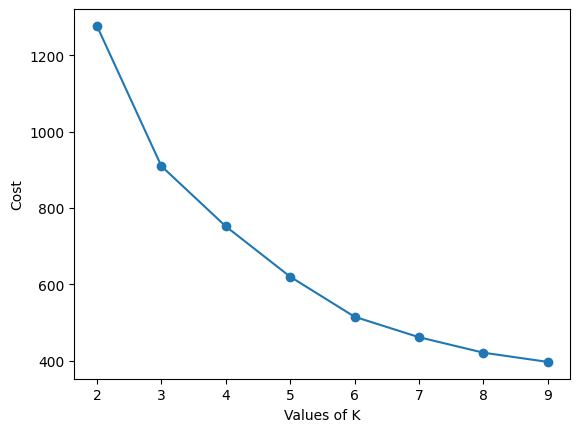

In [14]:
#import modules
import pandas as pd
import numpy as np
from kmodes import kprototypes
import matplotlib.pyplot as plt
#read data input

categorical_columns = ['Printer Requested', 'User Type', 'Material_Category1']
categorical_indices = [df.columns.get_loc(col) for col in categorical_columns]

#obtain array of values
data_array=df.values

elbow_scores = dict()
range_of_k = range(2,10) 
for k in range_of_k :
    untrained_model = kprototypes.KPrototypes(n_clusters=k)
    trained_model = untrained_model.fit(data_array, categorical=categorical_indices)
    elbow_scores[k]=trained_model.cost_
 
plt.plot(elbow_scores.keys(),elbow_scores.values())
plt.scatter(elbow_scores.keys(),elbow_scores.values())
plt.xlabel("Values of K") 
plt.ylabel("Cost") 
plt.show()

Once the cluster # was found, move to assigning each row a cluster to analyze.

In [15]:
all_features = df.columns

# Identify categorical columns (by name or index)
categorical_columns = ['Printer Requested', 'User Type', 'Material_Category1']
categorical_indices = [df.columns.get_loc(col) for col in categorical_columns]

# Prepare data: fill NA and convert to string for categorical, float for numeric
df_kproto = df[all_features].copy()
for col in categorical_columns:
    df_kproto[col] = df_kproto[col].astype(str)
for col in df_kproto.columns:
    if col not in categorical_columns:
        df_kproto[col] = pd.to_numeric(df_kproto[col], errors='coerce').fillna(0)

# Fit k-prototypes
clusters = 4
kproto = KPrototypes(n_clusters=clusters, random_state=42)
df['Cluster'] = kproto.fit_predict(df_kproto, categorical=categorical_indices)

# Print cluster sizes
print("\nCluster Sizes:")
print(df['Cluster'].value_counts().sort_index())

# Print characteristics of each cluster
print("\nCluster Characteristics:")
for cluster in range(clusters):
    print(f"\nCluster {cluster}:")
    cluster_data = df[df['Cluster'] == cluster]
    print("\nFeature Statistics:")
    print(cluster_data[all_features].describe(include='all').round(2))


Cluster Sizes:
Cluster
0      27
1    1289
2     510
3     102
Name: count, dtype: int64

Cluster Characteristics:

Cluster 0:

Feature Statistics:
       Printer Requested      User Type  Print Time (Hours) Material_Category1
count                 27             27               27.00                 27
unique                 4              2                 NaN                  3
top       Stratasys F370  Undergraduate                 NaN                ABS
freq                  12             22                 NaN                 14
mean                 NaN            NaN                6.10                NaN
std                  NaN            NaN                1.38                NaN
min                  NaN            NaN                4.30                NaN
25%                  NaN            NaN                4.93                NaN
50%                  NaN            NaN                6.09                NaN
75%                  NaN            NaN                6.81  

#### Analysis of clustering

Below are many graphs that highlight the clusters

This first one demonstrates that cluster 0 is the only one using the Stratasys printer. The rest are using a mix of formlabs and bambu primarily.

<Figure size 1200x800 with 0 Axes>

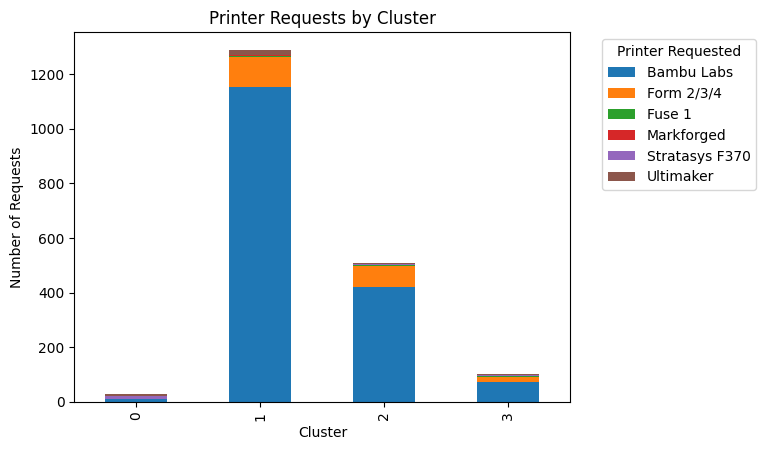

In [16]:
printer_counts = df.groupby(['Cluster', 'Printer Requested']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
printer_counts.plot(kind='bar', stacked=True)
plt.title('Printer Requests by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Requests')
plt.legend(title='Printer Requested', bbox_to_anchor=(1.05, 1), loc='upper left')

This pplot below demonstrates the print time distribution by cluster. Cluster 0 has the highest print time by far. All the other clusters are dsitributed and significantly different from each other. This is a primary defining feature of the clusters.

Text(0, 0.5, 'Print Time (Hours)')

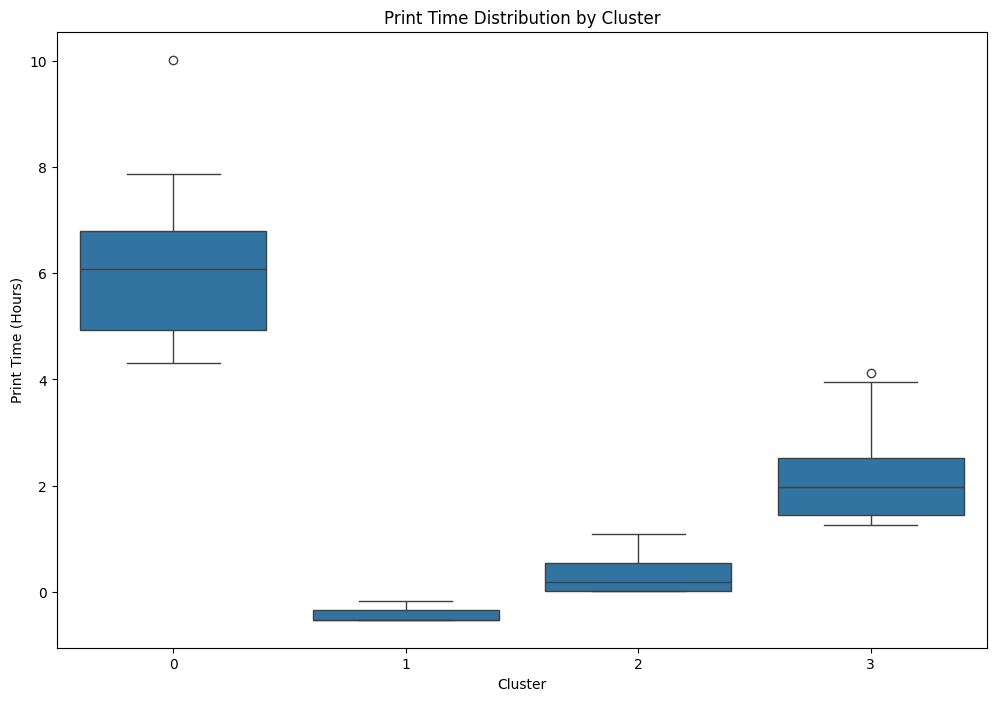

In [17]:
# Calculate statistics for each cluster
cluster_stats = df.groupby('Cluster')['Print Time (Hours)'].agg(['mean', 'std', 'median', 'min', 'max']).round(2)

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(12, 8))
 # Box plot
ax1 = sns.boxplot(x='Cluster', y='Print Time (Hours)', data=df, ax=ax)
ax1.set_title('Print Time Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Print Time (Hours)')
 

Below we can see the clusters are actually quite balanced based on demographic as well, negating our hypothesis that demographic would strongly correlate with what and how customers print in the space.

Text(0, 0.5, 'Cluster')

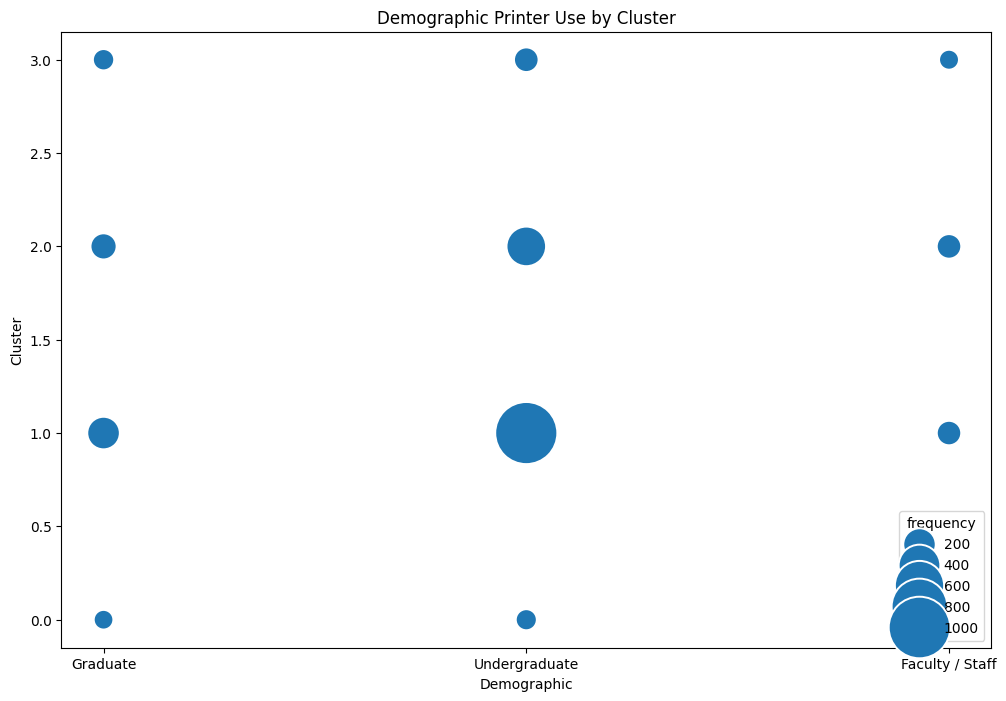

In [18]:
# Calculate statistics for each cluster
cluster_stats = df.groupby(['Cluster', 'User Type']).agg(['count'])
counts = df.groupby(['Cluster', 'User Type']).size().reset_index(name='frequency')
df_merged = pd.merge(df, counts, on=['Cluster', 'User Type'], how='left')

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(12, 8))
 # Box plot
ax1 = sns.scatterplot(x='User Type', y='Cluster',size='frequency',sizes=(200, 2000), data=df_merged, ax=ax)
ax1.set_title('Demographic Printer Use by Cluster')
ax1.set_xlabel('Demographic')
ax1.set_ylabel('Cluster')
 

Material use also has a minimal impact

Text(0, 0.5, 'Material Use')

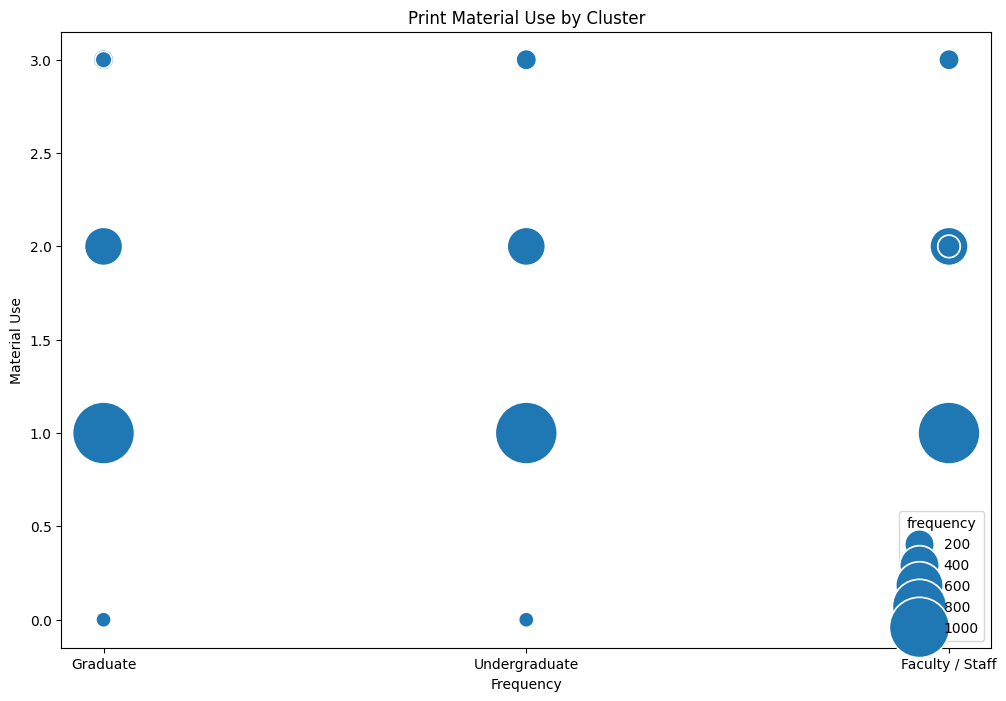

In [19]:
# Calculate statistics for each cluster
cluster_stats = df.groupby(['Cluster', 'Material_Category1']).agg(['count'])
counts = df.groupby(['Cluster', 'Material_Category1']).size().reset_index(name='frequency')
df_merged = pd.merge(df, counts, on=['Cluster', 'Material_Category1'], how='left')

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(12, 8))
 # Box plot
ax1 = sns.scatterplot(x='User Type', y='Cluster',size='frequency',sizes=(100, 2000), data=df_merged, ax=ax)
ax1.set_title('Print Material Use by Cluster')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Material Use')
 

#### K Prototypes Conclusion
Overall, the main clusters were based on time and specific printer use cases (Stratysys are heavily used by Formula SAE). This proves that moving forward, the most efficient batching strategy could be potentially have a small, medium and large print categories to assign with 

# Predictive Analysis

- Use a markdown cell to identify at least one question that can be addressed via predictive analysis. (E.g., “Can house prices be predicted based on the year they were built and the size of its lot?”)
- Implement an appropriate supervised learning algorithm to address the question(s) identified above, explaining your choice of algorithm over other methods and specifying the features and labels of your model(s).
- Include a ML pipeline with appropriate training/testing splits and, when applicable, cross-validation and hyperparameter tuning.
- Report your results using appropriate metrics and visualizations.
- Use Markdown cells to provide a written analysis.

The question we aim to address through our predictive analysis is whether we can accurately predict the number of people who will be coming in, using data on when people have come in the past.


Since the data we are predicting is continuous, that leaves us with regression. Choosing the type of regression is based on the features used to predict the label. In our case, we are using the time of day, so we opted for autoregression.


The label we are predicting will be a count of people coming in at a certain hour of a day.
The feature being used is the time of day.

In [20]:
# Load in fresh dataset
df = pd.read_csv('cleaned_dataset.csv')

# Turn Creation Log into datetime and take required infromation from it
df['Creation Log'] = pd.to_datetime(df['Creation Log'])
df['Day Time'] = df['Creation Log'].dt.floor('1h')
df['Weekday'] = df['Creation Log'].dt.day_name()
df['Date'] = df['Creation Log'].dt.date
df['Hour'] = df['Creation Log'].dt.hour

# Only use information from dataset that is needed
dft = df[['Day Time', 'Weekday', 'Date', 'Hour']]

In [21]:
# Find the number of people that came on a specific hour of the day
count_per_hour = dft.groupby(['Date', 'Hour']).size().reset_index(name='Count')

# Merge counts into main dataframe
dft = dft.merge(count_per_hour, on=['Date', 'Hour'], how='left')

# Drop columns that are no longer required
dft = dft.drop_duplicates(subset=['Date', 'Hour'])

In [22]:
# Set Day Time as index for autoregression
dft = dft.set_index('Day Time').sort_index()

# Remove first 2 and last row cause of incomplete day data
dft = dft.iloc[2:-1]

In [23]:
# Create rows for missing times
idx = pd.date_range(start='2025-01-06 00:00:00', end='2025-03-31 23:00:00', freq='1h')
dft = dft.reindex(idx)

# Fill new rows
dft['Weekday'] = dft.index.day_name()
dft = dft.fillna(value = 0)

In [24]:
# Split data into train and test
dft_train = dft.loc[:'2025-03-24 23:00:00']
dft_test = dft.loc['2025-03-25 00:00:00':]

# Split train data into another train and validation set
dft_train2 = dft_train.loc[:'2025-03-17 23:00:00']
dft_val = dft_train.loc['2025-03-18 00:00:00':]

In [25]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Find best lag to do autoregression on
scores = []
for i in range(1, 500):
    # Train model based on current lag
    model = AutoReg(dft_train2.Count, lags=i)
    model_fit = model.fit()

    # Predict the validation week counts
    yhat = model_fit.predict(start='2025-03-18 00:00:00', end='2025-03-24 23:00:00')

    # Add MSE error to scores list
    scores.append( mean_squared_error(dft_val.Count, yhat) )

# Find best lag from scores list
best_lag = scores.index(min(scores)) + 1
print(best_lag)

146


<Axes: xlabel='y(t)', ylabel='y(t + 146)'>

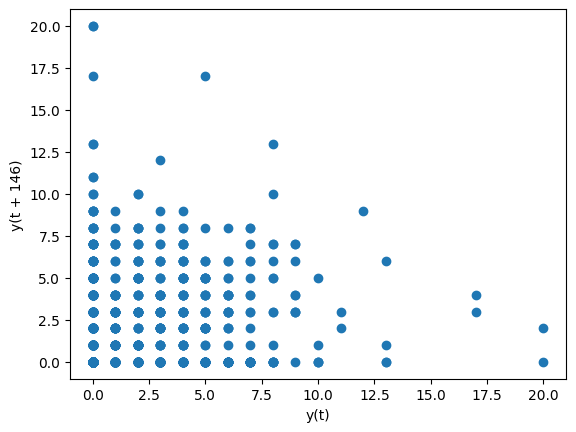

In [26]:
from pandas.plotting import lag_plot

# Make lag plot based on best lag
lag_plot(dft.Count, lag = best_lag)

/var/folders/f5/559_qhw57plby79lklrfrvm80000gn/T/ipykernel_59022/1285467392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_test["predictions"] = yhat


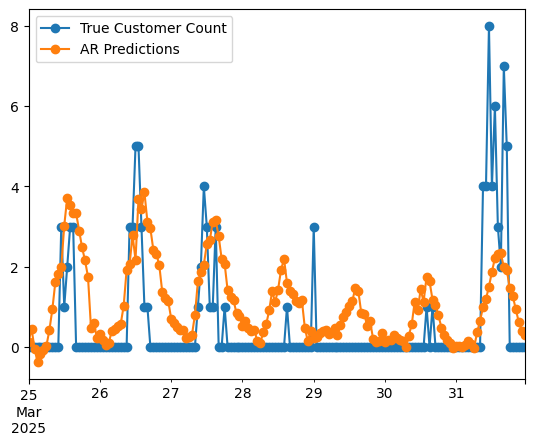

In [27]:
# Train autoregression on the best lag
model = AutoReg(dft_train.Count, lags = best_lag) # input the time series
model_fit = model.fit()

# Predict test week on new model
yhat = model_fit.predict(start='2025-03-25 00:00:00', end='2025-03-31 23:00:00')

# Plot predictions
dft_test["predictions"] = yhat

ax = dft_test.Count.plot(marker='o', label="True Customer Count")
dft_test.predictions.plot(ax=ax, marker='o', label='AR Predictions');
ax.legend();

**Lag Analysis**\
The lag that was found to predict the time series the best was 146. This implies that the last 6 days is the best to\
predict the current counts. Having the best lag be 6 days was not what we were expecting since that means it doesn't use\
the data from the same weekday of the last week.

**Autoregression Analysis**\
The autoregression predicts the Tuesday, Wednesday, and Thursday of the test week fairly well. However, the rest of the\
days as well as the following Monday are not predicted well. 

The oddness in how our data is set up is not helping the autoregression. A majority of the data entries are 0 with only\
the times of when the lab is open and other random times from staff having counts. This leads to the data not being\
incredibly consistent and messes with how the data gets predicted. The counts will also change week by week as certain\
events or assignments come up.

# Ethical Considerations

**Are there any ethical considerations regarding the dataset? (e.g., is it possible the data is biased?)**\
The Team Innovation Lab isn’t open to students on the weekends so the only prints on the weekend are staff. So there is some bias towards staff as they can print throughout the whole week versus students who can only print five days a week.

**Reflect on potential ethical implications of your analysis, such as privacy concerns, fairness, and the societal impact of the model if misused.**\
The Team Innovation Lab isn’t open to students on the weekends so the only prints on the weekend are staff. So there is some bias towards staff as they can print throughout the whole week versus students who can only print five days a week.

**Address ways to mitigate negative impacts of the analysis.**\
We have chosen to not use names after cleaning to avoid privacy issues that could be associated with them. We are just showing our findings in class and to the Team Innovations Lab instead of to the public to mitigate potential copying of ideas.

# Conclusion

- Use a Markdown cell to write a concise conclusion to your analysis. Did your analysis provide insight to this dataset? Were the results expected? If not, why?
- Highlight any limitations encountered.
- Describe at least one possible future direction based on your analysis and dataset. What are the challenges of pursuing this direction? If additional resources/data is needed, please specify.

### Results

We found that we can effectively cluster users into different segments using print data, and that going forward these segements can help the space decide how to organize the printers and assign them to students. We found that weekday trends for date time week over week are quite consistent, however in a given day it differs quite a lot. 

### Limitations

Since we had both numerical and categorical data, PCA and KMeans were both more difficult to do. For PCA we had to turn the categorical data into numbers to represent their category. This helped us be able to find principle component to describe our dataset. When doing K-Means we managed to find a different solution that uses both K-Means and K-Modes and helped us find clusters that uses the categories rather than requiring numbers.

During Autoregression we wanted to do predictive analysis on specific weekdays. However, this creates a 6 day gap between the different data entries and makes it more difficult running an Autoregressive model on it. This forced us to instead do day by day predictive analysis which is seen above.

### Future Direction
Collect samples going back multiple years to help augment clustering and trends in date and time that users come into print. Future decision trees and k prototypes labeling could help predict what batch of print a user is inserted into, effectively improving efficiency and use of the space. Over time, using autoregression could also improve staffing, though further research is required.